# **음악 스트리밍 서비스 kkbox의 고객 이탈률 예측**</br>


## **프로젝트의 필요성**</br>
> </br>
> 기업의 입장에서, 매출을 발생시키는 고객을 신규 유입시키는 데 발생하는 비용보다 기존 고객을 이탈하지 않도록 유지하는 비용이 더 낮음.
>
> 특히 음악 스트리밍과 같은 구독형 비즈니스 모델을 가진 서비스의 경우 기존 고객이 이탈하지 않도록 유지하는 것은 현재의 매출만이 아닌 미래의 현금 흐름 창출에도 중요한 요소로 작용.
> 
> 또한 고객의 이탈 데이터를 분석하여 현재 서비스 개선에 대한 의사결정의 근거를 마련할 수 있음.</br>
> </br>

## **목표**</br>
> </br>
> - 1차 : 머신 러닝을 통한 고객 전환 예측</br></br>
> - 2차 : 대쉬보드 생성</br></br>
> - 3차 : Slack을 통해 이탈 가능성이 높은 고객의 정보를 자동으로 전달할 수 있도록 시스템 구축</br>
></br>

## 추가적으로 생각해볼 수 있는 features

> </br>
> 사용자의 서비스 사용 횟수(일 단위) / 사용자의 총 서비스 가입 기간</br></br>
> </br></br>
> </br>
></br> 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import jiho_module as jm
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, datediff, sum, when, to_date, concat_ws, substring, lag, avg, count
from pyspark.sql.types import DateType
from pyspark.sql.window import Window

In [238]:
from importlib import reload
reload(jm)

<module 'jiho_module' from 'c:\\Users\\jiho\\Documents\\jiho_portfolio\\predict_churn_rate\\jiho_module.py'>

In [2]:
spark = SparkSession.builder.appName('predict_chrun_rate').getOrCreate()

In [3]:
train_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_train/new_train.parquet', inferSchema=True)
members_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_members/new_members.parquet', inferSchema=True)
transactions_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_transactions/new_transactions.parquet', inferSchema=True)
userlog_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_user_logs/new_user_logs-001.parquet', inferSchema=True)

In [3]:
train_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_train/new_train.parquet', inferSchema=True)
members_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_members/new_members.parquet', inferSchema=True)
transactions_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_transactions/new_transactions.parquet', inferSchema=True)
userlog_df = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_user_logs/new_user_logs-001.parquet', inferSchema=True)

### train_df 살펴보기

In [21]:
train_df_merged.printSchema()

root
 |-- msno: string (nullable = true)
 |-- is_churn: integer (nullable = true)



In [118]:
train_df_merged.count(), train_df_merged.select('msno').distinct().count()

(1963891, 1082190)

In [7]:
train_df_merged = train_df_merged.drop_duplicates(['msno'])

In [8]:
train_test = train_df_merged.unionAll(test)

In [9]:
test.select('msno').count()

907471

In [10]:
test.select('msno').distinct().count()

907471

In [11]:
train_test.select('msno').distinct().count()

1143472

In [124]:
train_df_merged.count()

1082190

In [20]:
test.filter(col('msno')==1).count()

0

In [6]:
print(train_df.filter(col('is_churn') == 0).count(), 
      train_df.filter(col('is_churn') == 1).count(), 
      round(train_df.filter(col('is_churn') == 1).count()/train_df.count()*100, 2), '%')
print(train_df_v2.filter(col('is_churn') == 0).count(), 
      train_df_v2.filter(col('is_churn') == 1).count(), 
      round(train_df_v2.filter(col('is_churn') == 1).count()/train_df_v2.count()*100, 2), '%')
print(train_df_merged.filter(col('is_churn') == 0).count(), 
      train_df_merged.filter(col('is_churn') == 1).count(), 
      round(train_df_merged.filter(col('is_churn') == 1).count()/train_df_v2.count()*100, 2), '%')

929460 63471 6.39 %
883630 87330 8.99 %
947710 134480 13.85 %


In [7]:
train_df_merged_grouped = train_df_merged.groupBy('is_churn').count()

In [9]:
train_df_merged_grouped.show()

+--------+------+
|is_churn| count|
+--------+------+
|       1|134480|
|       0|947710|
+--------+------+



In [22]:
np.array(train_df_merged_grouped.select('is_churn').collect()).reshape(-1)
np.array(train_df_merged_grouped.select('count').collect()).reshape(-1)

array([1, 0])

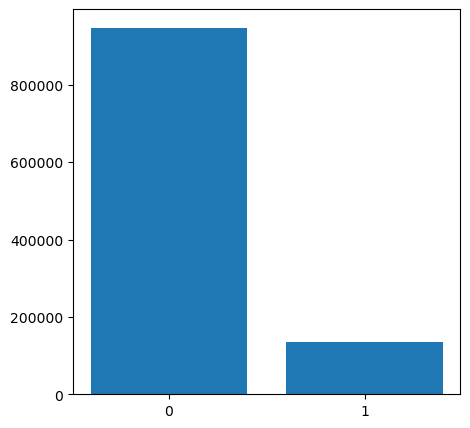

In [27]:
plt.figure(figsize=(5,5))
plt.bar(x=np.array(train_df_merged_grouped.select('is_churn').collect()).reshape(-1),
        height=np.array(train_df_merged_grouped.select('count').collect()).reshape(-1))
plt.xticks([0,1])
plt.show()

In [45]:
print(train_df.filter(col('msno').isNull()).count())
print(train_df.filter(col('is_churn').isNull()).count())
print(train_df_v2.filter(col('msno').isNull()).count())
print(train_df_v2.filter(col('is_churn').isNull()).count())

0
0
0
0


In [48]:
print(train_df.select('msno').distinct().count())
print(train_df_v2.select('msno').distinct().count())

992931
970960


### members_df 살펴보기

- members_df는 v2가 없고 v3만 있음
- v3는 2017년 11월 13일에 업데이트가 진행되었으며, 다른 데이터의 경우 2017년 3월 31일까지의 데이터만 담고 있음

In [49]:
members_df_v3.head()

Row(msno='Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=', city=1, bd=0, gender=None, registered_via=11, registration_init_time=20110911)

In [52]:
print('msno :', members_df_v3.filter(col('msno').isNull()).count())
print('city :', members_df_v3.filter(col('city').isNull()).count())
print('bd :',members_df_v3.filter(col('bd').isNull()).count())
print('gender :',members_df_v3.filter(col('gender').isNull()).count())
print('registered_via :',members_df_v3.filter(col('registered_via').isNull()).count())
print('registration_init_time :',members_df_v3.filter(col('registration_init_time').isNull()).count())

msno : 0
city : 0
bd : 0
gender : 4429505
registered_via : 0
registration_init_time : 0


In [54]:
print('bd == 0 :',members_df_v3.filter(col('bd')==0).count())

bd == 0 : 4540215


In [60]:
print('distinct city :', members_df_v3.select('city').distinct().orderBy(col('city')).collect())

distinct city : [Row(city=1), Row(city=3), Row(city=4), Row(city=5), Row(city=6), Row(city=7), Row(city=8), Row(city=9), Row(city=10), Row(city=11), Row(city=12), Row(city=13), Row(city=14), Row(city=15), Row(city=16), Row(city=17), Row(city=18), Row(city=19), Row(city=20), Row(city=21), Row(city=22)]


In [61]:
print('distinct registered_via :', members_df_v3.select('registered_via').distinct().orderBy(col('registered_via')).collect())

distinct registered_via : [Row(registered_via=-1), Row(registered_via=1), Row(registered_via=2), Row(registered_via=3), Row(registered_via=4), Row(registered_via=5), Row(registered_via=6), Row(registered_via=7), Row(registered_via=8), Row(registered_via=9), Row(registered_via=10), Row(registered_via=11), Row(registered_via=13), Row(registered_via=14), Row(registered_via=16), Row(registered_via=17), Row(registered_via=18), Row(registered_via=19)]


In [63]:
print('registered_via == -1 :', members_df_v3.filter(col('registered_via')==-1).count())

registered_via == -1 : 1


In [37]:
members_df_v3_groupby_city = members_df_v3.groupBy("city").count().select('*').orderBy('city')
members_df_v3_groupby_bd = members_df_v3.groupBy("bd").count().select('*').orderBy('bd')
members_df_v3_groupby_registered_via = members_df_v3.groupBy("registered_via").count().select('*').orderBy('registered_via')
members_df_v3_groupby_registration_init_time = members_df_v3.groupBy("registration_init_time").count().select('*').orderBy('registration_init_time')

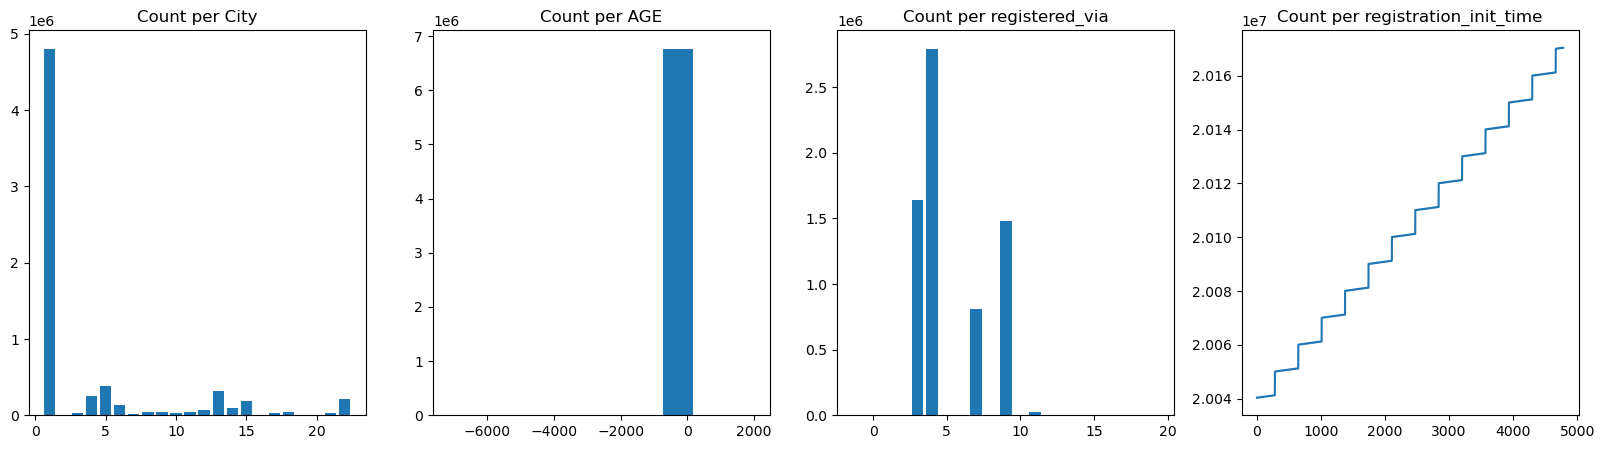

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.bar(x=np.array(members_df_v3_groupby_city.select('city').collect()).reshape(-1),
        height=np.array(members_df_v3_groupby_city.select('count').collect()).reshape(-1))
plt.title("Count per City")
plt.subplot(1,4,2)
plt.hist(x=np.array(members_df_v3.select('bd').collect()).reshape(-1))
plt.title("Count per AGE")
plt.subplot(1,4,3)
plt.bar(x=np.array(members_df_v3_groupby_registered_via.select('registered_via').collect()).reshape(-1),
        height=np.array(members_df_v3_groupby_registered_via.select('count').collect()).reshape(-1))
plt.title("Count per registered_via")
plt.subplot(1,4,4)
plt.plot(np.array(members_df_v3_groupby_registration_init_time.select('registration_init_time').collect()).reshape(-1))
plt.title("Count per registration_init_time")
plt.show()

In [73]:
print(members_df_v3.select(min('registration_init_time')).show())
print(members_df_v3.select(max('registration_init_time')).show())

+---------------------------+
|min(registration_init_time)|
+---------------------------+
|                   20040326|
+---------------------------+

None
+---------------------------+
|max(registration_init_time)|
+---------------------------+
|                   20170429|
+---------------------------+

None


### transaction_df 살펴보기

In [79]:
transactions_df_merged.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [90]:
transactions_df_merged.select('msno').distinct().count()

2426143

In [111]:
transactions_df_merged.head()

Row(msno='YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=', payment_method_id=41, payment_plan_days=30, plan_list_price=129, actual_amount_paid=129, is_auto_renew=1, transaction_date=20150930, membership_expire_date=20151101, is_cancel=0)

In [107]:
transactions_df_merged.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20150101|              20171106|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20150104|              20171207|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               119|            1|        20150123|              20180107|        0|
|hqWmt5OeZ3ab3MZdX...|               41|            

In [110]:
print(
    transactions_df.select(min('transaction_date')).show(),
    transactions_df.select(max('transaction_date')).show(),
    transactions_df_v2.select(min('transaction_date')).show(),
    transactions_df_v2.select(max('transaction_date')).show()
)

+---------------------+
|min(transaction_date)|
+---------------------+
|             20150101|
+---------------------+

+---------------------+
|max(transaction_date)|
+---------------------+
|             20170228|
+---------------------+

+---------------------+
|min(transaction_date)|
+---------------------+
|             20150101|
+---------------------+

+---------------------+
|max(transaction_date)|
+---------------------+
|             20170331|
+---------------------+

None None None None


In [115]:
print(
    transactions_df.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show(),
    transactions_df_v2.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show()
    )

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151223|              20160123|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151224|              20130602|        1|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151224|              20131226|        1|
|hqWmt5OeZ3ab3MZdX...|               41|            

In [119]:
print(
    'payment_method_id : ', transactions_df_merged.select('payment_method_id').distinct().orderBy('payment_method_id').collect(), '\n',
    'payment_plan_days : ', transactions_df_merged.select('payment_plan_days').distinct().orderBy('payment_plan_days').collect(), '\n',
    'plan_list_price : ', transactions_df_merged.select('plan_list_price').distinct().orderBy('plan_list_price').collect(), '\n',
    'actual_amount_paid : ', transactions_df_merged.select('actual_amount_paid').distinct().orderBy('actual_amount_paid').collect(), '\n',
    'is_auto_renew : ', transactions_df_merged.select('is_auto_renew').distinct().orderBy('is_auto_renew').collect()
)

payment_method_id :  [Row(payment_method_id=1), Row(payment_method_id=2), Row(payment_method_id=3), Row(payment_method_id=4), Row(payment_method_id=5), Row(payment_method_id=6), Row(payment_method_id=7), Row(payment_method_id=8), Row(payment_method_id=10), Row(payment_method_id=11), Row(payment_method_id=12), Row(payment_method_id=13), Row(payment_method_id=14), Row(payment_method_id=15), Row(payment_method_id=16), Row(payment_method_id=17), Row(payment_method_id=18), Row(payment_method_id=19), Row(payment_method_id=20), Row(payment_method_id=21), Row(payment_method_id=22), Row(payment_method_id=23), Row(payment_method_id=24), Row(payment_method_id=25), Row(payment_method_id=26), Row(payment_method_id=27), Row(payment_method_id=28), Row(payment_method_id=29), Row(payment_method_id=30), Row(payment_method_id=31), Row(payment_method_id=32), Row(payment_method_id=33), Row(payment_method_id=34), Row(payment_method_id=35), Row(payment_method_id=36), Row(payment_method_id=37), Row(payment_me

### user_log 데이터 살펴보기

In [120]:
user_logs_df.head()

Row(msno='rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=', date=20150513, num_25=0, num_50=0, num_75=0, num_985=0, num_100=1, num_unq=1, total_secs=280.335)

In [22]:
user_logs_df_merged = user_logs_df.union(user_logs_df_v2)

In [127]:
user_logs_df_merged.select(min('date')).show()

+---------+
|min(date)|
+---------+
| 20150101|
+---------+



In [129]:
print(
    'msno : ', user_logs_df_merged.filter(col('msno').isNull()).count(), '\n',
    'date : ', user_logs_df_merged.filter(col('date').isNull()).count(),'\n',
    'num_25 : ', user_logs_df_merged.filter(col('num_25').isNull()).count(),'\n',
    'num_50 : ', user_logs_df_merged.filter(col('num_50').isNull()).count(),'\n',
    'num_75 : ', user_logs_df_merged.filter(col('num_75').isNull()).count(),'\n',
    'num_985 : ', user_logs_df_merged.filter(col('num_985').isNull()).count(),'\n',
    'num_100 : ', user_logs_df_merged.filter(col('num_100').isNull()).count(),'\n',
    'num_unq : ', user_logs_df_merged.filter(col('num_unq').isNull()).count(),'\n',
    'total_secs : ', user_logs_df_merged.filter(col('total_secs').isNull()).count()
)


msno :  0 
 date :  0 
 num_25 :  0 
 num_50 :  0 
 num_75 :  0 
 num_985 :  0 
 num_100 :  0 
 num_unq :  0 
 total_secs :  0


In [71]:
transactions_df_merged.columns

Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel'],
      dtype='object')

In [73]:
active_count =  user_logs_df_merged.groupBy("msno")[['num_25']].agg('count').rename(columns={'num_25' : 'active_days'}).reset_index()
paid_user = transactions_df_merged.groupBy("msno")[['is_cancel']].agg('count').rename(columns={'is_cancel' : 'transaction_count'}).reset_index()

In [36]:
len(transactions_df_merged.select('msno').distinct())

2426143

In [74]:
len(active_count), len(paid_user)

(5339422, 2426143)

In [59]:
len(members_df_v3)

6769473

In [ ]:
len(members_df_v3)

In [62]:
active_count.head(10)

,msno,active_days
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,142
1,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,680
2,PNxIsSLWOJDCm7pNPFzRO/6Mmg2WeZA2nf6hw6t1x3g=,119
3,KXF9c/T66LZIzFq+xS64icWMhDQE6miCZAtdXRjZHX8=,198
4,oy2721XIrBu+MEh8XjPTlt5b7gCronoHf/oFN+YwIv8=,502
5,zD6AnHn/qhjoROJjnwmKUsKJ1Xj4nZ3fJzVShr+LISo=,742
6,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,646
7,FnqNUBvN8mysLeKba1tBkGZDLM1DhvC5iloOKM1wiuQ=,575
8,dW5DQO92XaG024D2QYmktyUnLc2axil74zUPAhF8sEs=,612
9,6QoLmaBbt/q8hVY7VBT72CurH3dTd6TT/7rK3qfwxqg=,213


In [16]:
transactions_df_v2.filter(col('msno') == 'ORUaiH4z66kfVaKGvnC4qukcfhCLY9X9Y2LWcLncvYo=').show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|ORUaiH4z66kfVaKGv...|               41|               30|             99|                99|            1|        20170322|              20170422|        0|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+



## 데이터 병합

In [56]:
transaction_grouped = transactions_df_merged.groupBy('msno').count()
logs_grouped = user_logs_df_merged.groupBy('msno').count()

In [57]:
train_memeber = train_df_merged.join(members_df_v3, on='msno', how='left')
train_transaction = train_df_merged.join(transaction_grouped, on='msno', how='left')
train_log = train_df_merged.join(logs_grouped, on='msno', how='left')

In [58]:
print(train_memeber.filter(col('city').isNotNull()).count(), train_memeber.filter(col('city').isNull()).count())
print(train_transaction.filter(col('count').isNotNull()).count(), train_transaction.filter(col('count').isNull()).count())
print(train_log.filter(col('count').isNotNull()).count(), train_log.filter(col('count').isNull()).count())

961431 120759
1082190 0
955159 127031


In [ ]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='inner').join(transaction_grouped, on='msno', how='inner').join(logs_grouped, on='msno', how='inner')

In [62]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='left').join(transaction_grouped, on='msno', how='left').join(logs_grouped, on='msno', how='left')

In [64]:
df_target.count()

1082190

In [6]:
transactions_df_merged = transactions_df_merged.withColumn('prev_expire_date', lag('membership_expire_date').over(Window.partitionBy('msno').orderBy('transaction_date','membership_expire_date')))

In [7]:
transactions_df_merged = transactions_df_merged.withColumn('periods', when(transactions_df_merged.is_cancel == 0, datediff(transactions_df_merged['membership_expire_date'], transactions_df_merged['transaction_date']))
                                             .otherwise(datediff(transactions_df_merged['membership_expire_date'], transactions_df_merged['prev_expire_date']))
                                )

In [8]:
transaction_total_periods_per_user = transactions_df_merged.groupBy("msno").agg(sum('periods').alias('total_periods'))

In [15]:
logs_grouped = user_logs_df_merged.groupBy('msno').count()
logs_grouped = logs_grouped.join(transaction_total_periods_per_user, on='msno', how='left')
logs_grouped = logs_grouped.withColumn('active_per_periods', col('count') / col('total_periods'))

In [17]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='inner').join(logs_grouped, on='msno', how='inner')

In [24]:
transaction_total_periods_per_user.columns

['msno', 'total_periods']

In [19]:
df_target = df_target.drop('msno')

In [20]:
df_target.columns

['is_churn',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'count',
 'total_periods',
 'active_per_periods']

In [21]:
df_target.toPandas().to_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target2.csv')

In [23]:
df_target.count()

955126

In [26]:
df20230408 = pd.read_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target3.csv')

<AxesSubplot: xlabel='active_per_periods', ylabel='Density'>

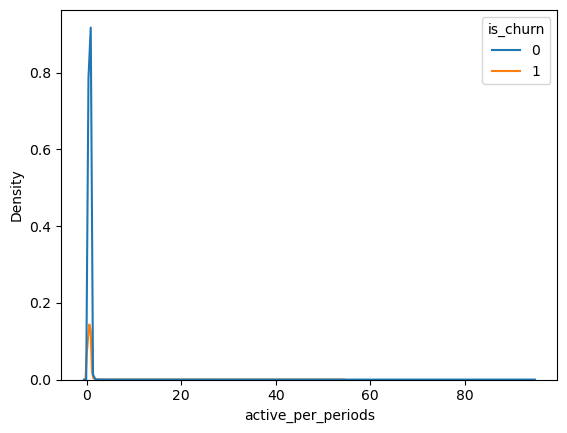

In [38]:
sns.kdeplot(data=df20230408, x='active_per_periods', hue='is_churn')

In [27]:
transactions_df.printSchema()

root
 |-- msno_num: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [4]:
transactions_df_grouped = transactions_df.groupBy('msno_num').count()
userlog_df_grouped = userlog_df.groupBy('msno_num').count()

In [5]:
userlog_df_grouped.count()

5339422

In [5]:
train_member = train_df.join(members_df, on='msno_num', how='inner')

In [6]:
train_member_transaction = train_member.join(transactions_df_grouped, on='msno_num', how='inner')
train_memeber_log = train_member.join(userlog_df_grouped, on='msno_num', how='inner')

In [7]:
train_member_transaction_log = train_member_transaction.join(train_memeber_log, on='msno_num', how='inner')

In [8]:
target_id = train_member_transaction_log.select('msno_num')

In [9]:
sample = target_id.sample(0.005)

In [10]:
pd_sample = sample.toPandas()

In [11]:
train_sample = train_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))
members_sample = members_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))
transaction_sample = transactions_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))
userlog_sample = userlog_df.filter(col('msno_num').isin(list(pd_sample['msno_num'])))

In [14]:
train_sample.write.parquet('D:/kkbox-churn-prediction-challenge/data/sample/train_random_sample.parquet')
members_sample.write.parquet('D:/kkbox-churn-prediction-challenge/data/sample/members_random_sample.parquet')
transaction_sample.write.parquet('D:/kkbox-churn-prediction-challenge/data/sample/transaction_random_sample.parquet')

In [34]:
total_periods = transactions_df_merged.groupBy('msno').agg(sum('periods').alias('total_periods'))

In [7]:
user_log_avg = (user_logs_df_merged
                .groupBy('msno')
                .agg(count('*').alias('count'), avg('num_25') ,avg('num_50'), avg('num_75'),avg('num_985'),avg('num_100'),avg('num_unq'),avg('total_secs'))
                )

In [265]:
train_df = pd.read_parquet('./sample_data/sample_train.parquet')
members_df = pd.read_parquet('./sample_data/sample_members.parquet')
transaction_df = pd.read_parquet('./sample_data/sample_transactions.parquet')
userlog_df = pd.read_parquet('./sample_data/sample_user_logs.parquet')

In [347]:
(train_df['is_churn'] == 0).sum(), (train_df['is_churn'] == 1).sum()

(13356, 1943)

## Transaction_data EDA

In [416]:
transaction_df['year_month'] = pd.to_datetime(transaction_df['transaction_date'].dt.strftime('%Y%m'), format='%Y%m')

In [425]:
transaction_df[transaction_df.duplicated(['msno_num', 'year_month'], keep=False)].sort_values('msno_num').head(60)

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,year_month
201001,1429,41,30,129,129,1,2016-12-03,2017-01-02,0,2016-12-01
201003,1429,41,30,149,149,1,2016-12-03,2016-12-03,1,2016-12-01
85112,2994,41,30,129,129,1,2015-12-03,2016-01-04,0,2015-12-01
85123,2994,41,30,129,129,1,2015-12-29,2015-12-29,1,2015-12-01
85133,2994,35,7,0,0,0,2015-12-29,2016-01-12,0,2015-12-01
107621,5883,41,30,149,149,1,2016-05-23,2016-05-23,1,2016-05-01
107615,5883,41,30,129,129,1,2016-05-23,2016-06-23,0,2016-05-01
224243,11835,40,30,149,149,1,2016-07-13,2016-08-12,0,2016-07-01
224236,11835,41,30,149,149,1,2016-07-07,2016-07-08,1,2016-07-01
224239,11835,41,30,149,149,1,2016-07-06,2016-08-06,0,2016-07-01


In [266]:
transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'], format='%Y%m%d')
transaction_df['membership_expire_date'] = pd.to_datetime(transaction_df['membership_expire_date'], format='%Y%m%d')

In [267]:
transaction_filter1 = (transaction_df['transaction_date'] < transaction_df['membership_expire_date'])
transaction_filter2 = ((transaction_df['membership_expire_date'] - transaction_df['transaction_date']).dt.days < transaction_df['payment_plan_days'] * 3)

In [268]:
transaction_df_filtered = transaction_df[transaction_filter1 & transaction_filter2]

In [269]:
transaction_df_filtered.loc[:,'lag_membership_expire_date'] = transaction_df_filtered.sort_values(by='membership_expire_date', ascending=True).groupby('msno_num')['membership_expire_date'].shift(1)

C:\Users\jiho\AppData\Local\Temp\ipykernel_13340\1994290194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_df_filtered.loc[:,'lag_membership_expire_date'] = transaction_df_filtered.sort_values(by='membership_expire_date', ascending=True).groupby('msno_num')['membership_expire_date'].shift(1)


In [270]:
transaction_df_filtered.loc[:,'period'] = np.where(
    transaction_df_filtered['is_cancel'] == 0 ,
    (transaction_df_filtered['membership_expire_date'] - transaction_df_filtered['transaction_date']).dt.days,
    (transaction_df_filtered['lag_membership_expire_date'] - transaction_df_filtered['membership_expire_date']).dt.days
)

C:\Users\jiho\AppData\Local\Temp\ipykernel_13340\1936647700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_df_filtered.loc[:,'period'] = np.where(


In [353]:
transaction_df_filtered.groupby('msno')

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,lag_membership_expire_date,period
0,17474,36,30,180,180,0,2017-03-01,2017-03-31,0,NaT,30.0
1,64005,41,30,149,149,1,2015-02-17,2015-03-17,0,2015-02-17,28.0
2,64005,41,30,149,149,1,2016-04-10,2016-05-10,0,2016-04-10,30.0
4,64005,41,30,149,149,1,2017-02-10,2017-03-10,0,2017-02-10,28.0
5,64005,41,30,149,149,1,2016-12-10,2017-01-10,0,2016-12-10,31.0
...,...,...,...,...,...,...,...,...,...,...,...
253190,7169736,36,30,180,180,0,2016-06-24,2016-07-24,0,2016-05-21,30.0
253191,7169736,32,195,894,894,0,2015-11-05,2016-05-21,0,NaT,198.0
253192,7169736,32,195,894,894,0,2016-07-26,2017-02-09,0,2016-07-24,198.0
253193,7169736,32,195,894,894,0,2017-02-10,2017-08-27,0,2017-02-09,198.0


<AxesSubplot: ylabel='Count'>

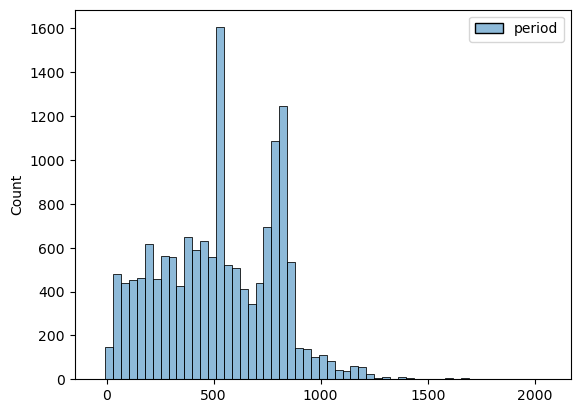

In [271]:
sns.histplot(transaction_df_filtered.groupby('msno_num')[['period']].sum())

In [350]:
transaction_autorenew = transaction_df_filtered.groupby('msno_num')[['is_auto_renew']].sum()
transaction_autorenew
train_autorenew =train_df.join(transaction_autorenew, on='msno_num', how='inner')

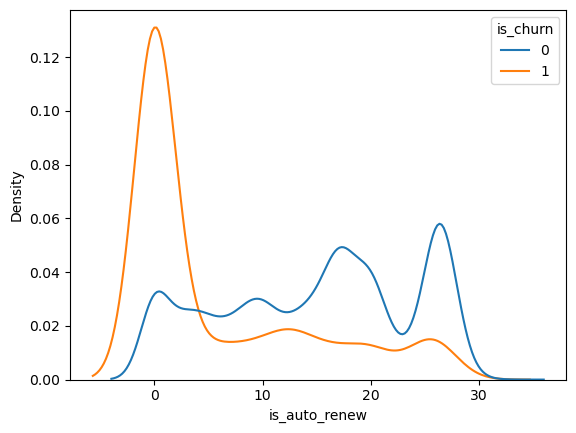

In [351]:
jm.compare_density(train_autorenew, 'is_auto_renew')

<AxesSubplot: ylabel='Count'>

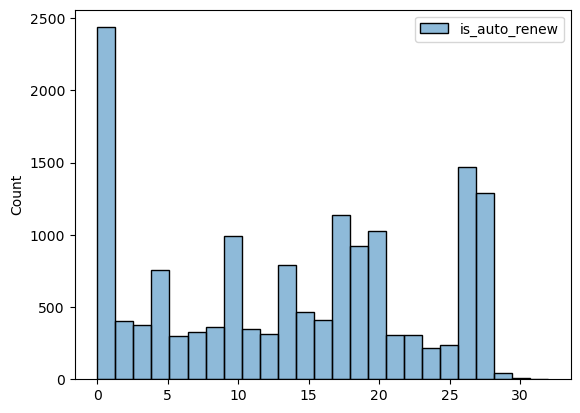

In [343]:
sns.histplot(transaction_df_filtered.groupby('msno_num')[['is_auto_renew']].sum(), hue='is_churn')

In [272]:
train_period = train_df.join(transaction_df_filtered.groupby('msno_num')[['period']].sum(), on='msno_num', how='inner')

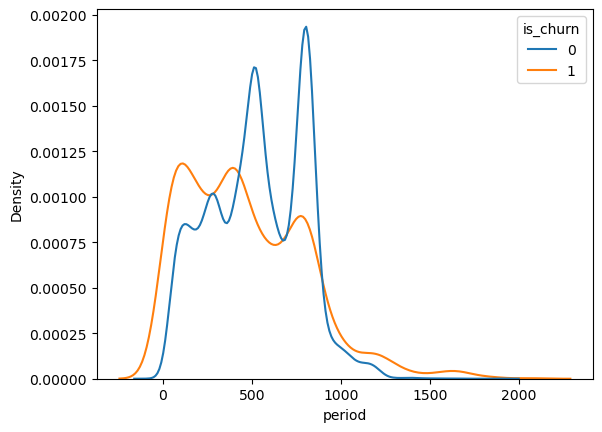

In [273]:
jm.compare_density(train_period, 'period')

## User Log EDA

In [274]:
userlog_df[userlog_df.total_secs > 86400]
userlog_filter1 = (userlog_df.total_secs > 0)
userlog_df_filtered = userlog_df[userlog_filter1]

In [275]:
userlog_df_filtered

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,311995,20150127,6,3,2,2,25,22,7311.623
1,311995,20150520,4,1,2,0,13,12,3252.325
2,311995,20150728,0,1,0,0,12,11,3135.897
3,311995,20151125,2,0,2,3,27,20,6353.843
4,311995,20160418,0,0,0,0,21,14,2991.098
...,...,...,...,...,...,...,...,...,...
4454855,7301526,20161226,4,1,4,1,50,10,12926.347
4454856,7301526,20161228,0,1,3,0,6,2,1969.598
4454857,7301526,20170103,0,0,1,1,0,2,337.562
4454858,7301526,20170104,1,1,1,1,8,5,2353.406


(0.0, 500000.0)

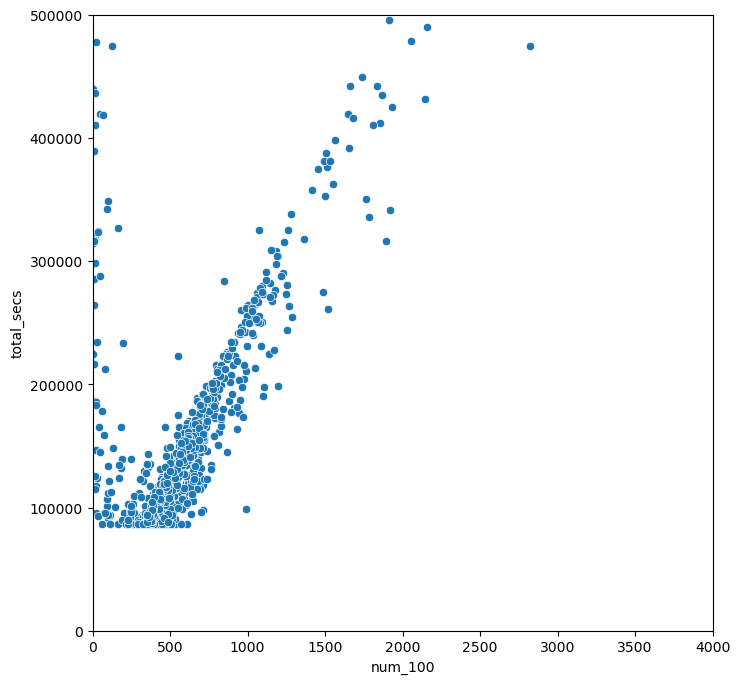

In [278]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=(userlog_df_filtered[userlog_df_filtered.total_secs > 86400].num_100), y=userlog_df_filtered[userlog_df_filtered.total_secs > 86400].total_secs)
plt.xlim([0, 4000])
plt.ylim([0,500000])

In [430]:
userlog_df_filtered[userlog_df_filtered['total_secs'] > 86400].sort_values(['msno_num', 'date']).head(60)

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1943260,12089,20150117,48,7,5,7,94,134,101013.947
3991037,13077,20150625,17,4,6,6,1145,628,271196.860
3991059,13077,20150628,50,6,8,3,580,443,138894.790
3991114,13077,20150706,21,2,2,5,1067,640,250732.186
3991227,13077,20150716,25,6,5,6,640,513,152449.651
3991293,13077,20150726,120,6,10,4,1651,775,391665.369
3991348,13077,20150801,40,1,9,2,543,484,131602.505
3991089,13077,20160924,18,3,2,5,600,503,147022.354
3991258,13077,20161210,46,4,2,6,428,417,102788.495
2116351,96195,20170329,1,2,0,1,698,84,144703.156


In [438]:
userlog_df_filtered[(userlog_df_filtered['msno_num'] == 13077)].sort_values('date').head(60)

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
3991136,13077,20150513,7,2,0,1,18,28,4815.581
3991148,13077,20150514,4,0,0,2,42,47,9942.073
3991160,13077,20150515,1,0,2,1,107,106,26411.133
3991171,13077,20150516,0,2,1,0,148,137,36097.366
3991182,13077,20150517,52,15,6,11,75,120,24536.671
3991193,13077,20150518,29,7,3,6,36,67,12459.938
3991204,13077,20150519,2,2,0,1,7,11,2590.673
3991215,13077,20150520,5,5,4,2,3,15,2356.578
3991226,13077,20150521,18,1,1,5,14,30,5333.441
3991237,13077,20150522,4,0,1,3,35,41,10221.272


In [279]:
userlog_df_grouped_avg = (userlog_df_filtered
                          .groupby('msno_num')
                          .agg({
                            'msno_num' : 'count',
                            'num_25' : 'mean',
                            'num_50' : 'mean',
                            'num_75' : 'mean',
                            'num_985' : 'mean',
                            'num_100' : 'mean',
                            'num_unq' : 'mean',
                            'total_secs' : 'mean'
                          })
                          )

In [282]:
train_df

,msno_num,is_churn
0,12120,0
1,13193,0
2,17474,1
3,19991,0
4,20371,0
...,...,...
15294,7362310,0
15295,7363415,0
15296,7373309,1
15297,7373344,0


In [280]:
userlog_df_grouped_avg

,msno_num,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
msno_num,,,,,,,,
1400,175,0.520000,0.262857,0.308571,0.377143,76.097143,58.777143,17091.255457
1429,277,8.400722,1.927798,1.368231,1.620939,19.072202,24.599278,5738.887285
2994,582,18.369416,2.347079,1.321306,1.237113,39.144330,56.785223,10310.834806
3018,270,9.303704,1.777778,0.944444,0.562963,16.218519,23.881481,4430.969270
3397,535,3.609346,0.930841,0.642991,0.616822,16.551402,18.186916,4280.917465
...,...,...,...,...,...,...,...,...
7374403,85,2.141176,0.741176,0.400000,0.423529,66.741176,39.964706,17078.558294
7375076,21,4.380952,1.285714,0.476190,0.476190,4.666667,10.095238,1649.737476
7375630,47,4.553191,2.340426,1.297872,0.936170,1.957447,9.382979,1229.187000


In [281]:
train_log = train_df.join(userlog_df_grouped_avg, on='msno_num', how='inner', )

ValueError: columns overlap but no suffix specified: Index(['msno_num'], dtype='object')

In [262]:
train_log

,msno_num,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,12120,0,8.309783,1.961957,1.177536,0.851449,18.677536,22.920290,5070.038375
1,13193,0,1.086614,0.328084,0.309711,0.451444,12.341207,13.598425,3528.667079
2,17474,1,2.964286,2.071429,1.392857,4.428571,24.428571,27.321429,7721.734107
3,19991,0,4.103448,0.793103,0.241379,0.793103,26.241379,27.241379,6884.835000
4,20371,0,5.052632,1.421053,1.093567,0.771930,21.122807,25.081871,4685.818275
...,...,...,...,...,...,...,...,...,...
15294,7362310,0,8.589641,2.398406,1.722444,1.555113,26.579017,36.266932,7794.794839
15295,7363415,0,6.939114,1.297048,1.114391,1.012915,18.822878,26.964945,5112.401839
15296,7373309,1,5.890578,1.641337,1.471125,1.285714,106.234043,88.194529,25573.025778
15297,7373344,0,2.000000,0.400000,0.200000,1.000000,2.400000,4.000000,827.759800


In [358]:
train_log_drop_outlier = train_log.drop(index=6013)

In [405]:
# 각 값에서 0 빼고 계산을 해야 의미가 있지 않을까?

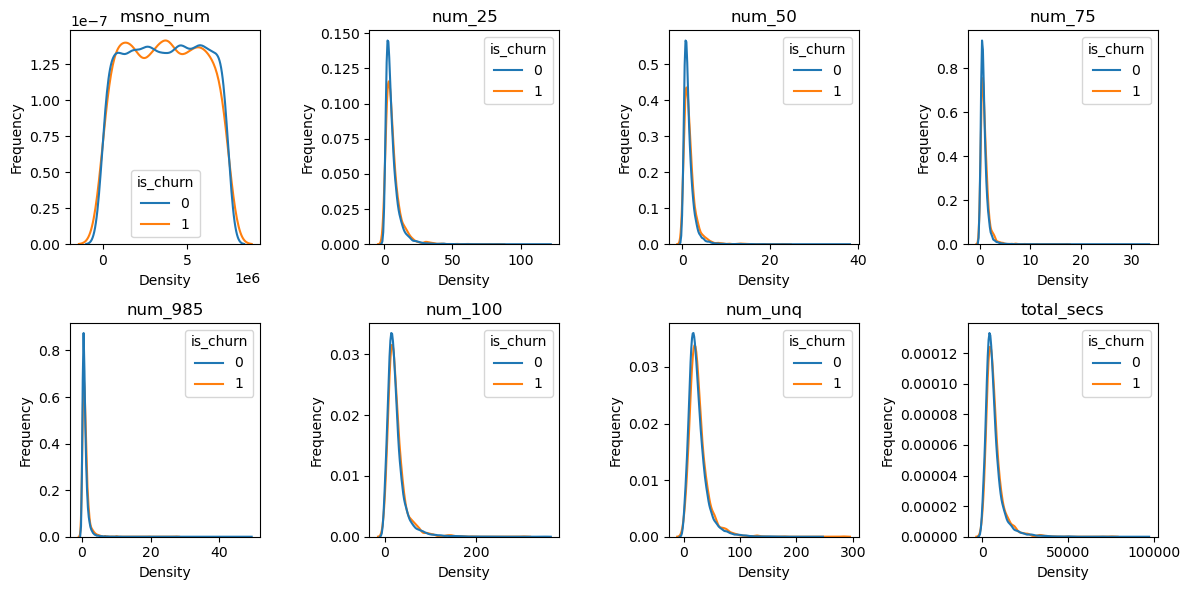

In [359]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for idx, col in enumerate(['msno_num', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']):
    ax = axs.flatten()[idx]
    jm.compare_density(train_log_drop_outlier, col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Density')
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [287]:
train_log[train_log['is_churn'] == 0]['total_secs'].mean(), train_log[train_log['is_churn'] == 1]['total_secs'].mean()

(1099654482.137567, 6952.987861029869)

In [289]:
(train_log[train_log['is_churn'] == 0]['total_secs']).max()

14686898154304.082

<AxesSubplot: ylabel='total_secs'>

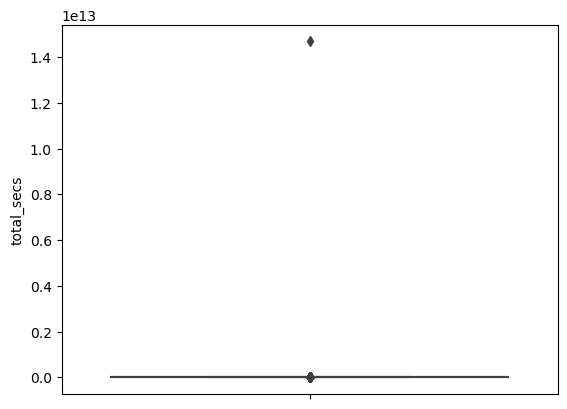

In [355]:
sns.boxplot(data=train_log, y='total_secs')

In [357]:
train_log[train_log['total_secs'] > 259200]

,msno_num,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
6013,5599444,0,1.737261,0.417197,0.340764,0.43949,25.914013,22.292994,1.468690e+13


In [320]:
userlog_df['date'] =pd.to_datetime(userlog_df['date'], format='%Y%m%d')

<AxesSubplot: xlabel='date', ylabel='Count'>

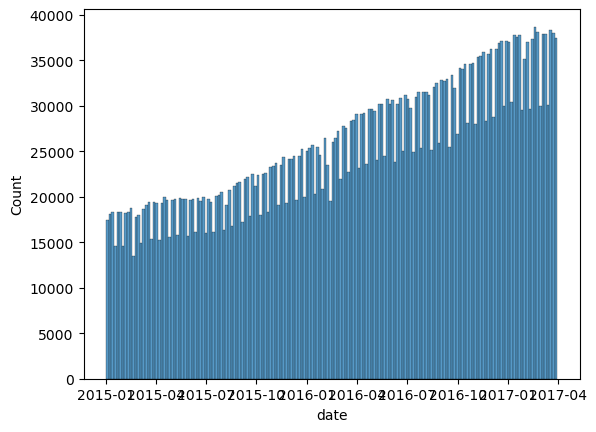

In [170]:
# 유저 로그가 선형적으로 증가하는 모습을 보임
# 주기성은 어느정도 있는 것으로 보임

sns.histplot(userlog_df['date'])

In [334]:
linear_score = dict(zip(pd.to_datetime(pd.date_range('2015-01-01', '2017-03-31'), '%Y%m%d'), np.linspace(0,1,821)))
square_score = dict(zip(pd.to_datetime(pd.date_range('2015-01-01', '2017-03-31'), '%Y%m%d'), np.square(np.linspace(0,1,821))))

In [335]:
userlog_df['active_score_linear'] = userlog_df['date'].map(linear_score)
userlog_df['active_score_square'] = userlog_df['date'].map(square_score)

In [336]:
userlog_df

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,active_score,active_score_linear,active_score_square
0,311995,2015-01-27,6,3,2,2,25,22,7311.623,0.001005,0.031707,0.001005
1,311995,2015-05-20,4,1,2,0,13,12,3252.325,0.028734,0.169512,0.028734
2,311995,2015-07-28,0,1,0,0,12,11,3135.897,0.064343,0.253659,0.064343
3,311995,2015-11-25,2,0,2,3,27,20,6353.843,0.160000,0.400000,0.160000
4,311995,2016-04-18,0,0,0,0,21,14,2991.098,0.332732,0.576829,0.332732
...,...,...,...,...,...,...,...,...,...,...,...,...
4454855,7301526,2016-12-26,4,1,4,1,50,10,12926.347,0.781715,0.884146,0.781715
4454856,7301526,2016-12-28,0,1,3,0,6,2,1969.598,0.786034,0.886585,0.786034
4454857,7301526,2017-01-03,0,0,1,1,0,2,337.562,0.799062,0.893902,0.799062
4454858,7301526,2017-01-04,1,1,1,1,8,5,2353.406,0.801243,0.895122,0.801243


In [337]:
user_active_score_lin = userlog_df.groupby('msno_num')[['active_score_linear']].mean()
user_active_score_sqr = userlog_df.groupby('msno_num')[['active_score_square']].mean()

In [338]:
train_user_active_lin = train_df.join(user_active_score_lin, on='msno_num', how='inner')
train_user_active_sqr = train_df.join(user_active_score_sqr, on='msno_num', how='inner')

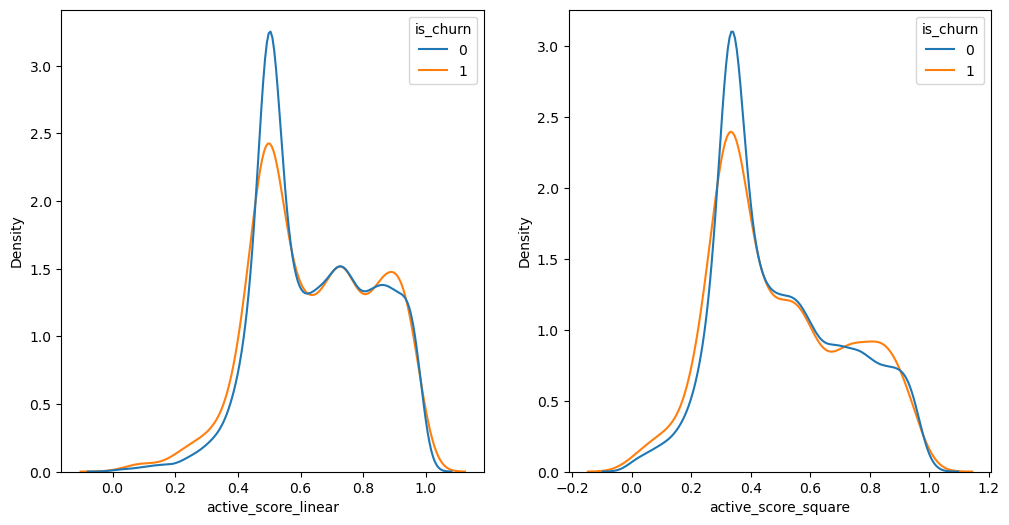

In [341]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
jm.compare_density(train_user_active_lin, 'active_score_linear')

plt.subplot(1,2,2)
jm.compare_density(train_user_active_sqr, 'active_score_square')

In [386]:
userlog_df_orderby_date = userlog_df.sort_values(['msno_num', 'date'])

day = pd.Timedelta('1d')

m = userlog_df_orderby_date.groupby('msno_num')['date'].diff().gt(day).cumsum()

In [388]:
m = userlog_df_orderby_date.groupby('msno_num')['date'].diff().gt(day).cumsum()

In [397]:
userlog_df_orderby_date['max_consecutive'] = userlog_df_orderby_date['msno_num'].map(userlog_df_orderby_date.groupby(['msno_num', m]).size().max(level='msno_num'))

C:\Users\jiho\AppData\Local\Temp\ipykernel_13340\4099301429.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  userlog_df_orderby_date['max_consecutive'] = userlog_df_orderby_date['msno_num'].map(userlog_df_orderby_date.groupby(['msno_num', m]).size().max(level='msno_num'))


In [401]:
userlog_consecutive_group = userlog_df_orderby_date.groupby('msno_num')[['max_consecutive']].max()

In [402]:
train_consecutive = train_df.join(userlog_consecutive_group, on='msno_num', how='inner')

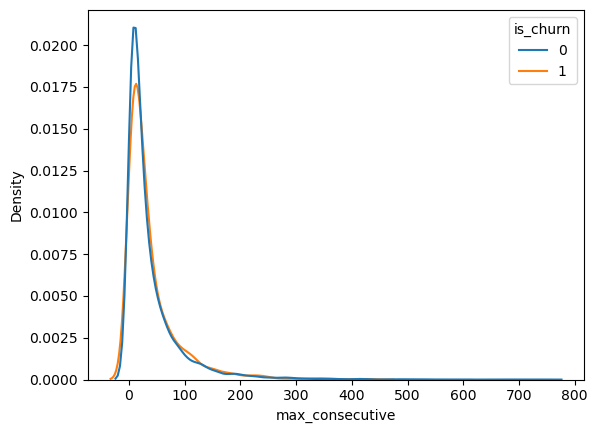

In [404]:
jm.compare_density(train_consecutive, 'max_consecutive')

In [381]:
userlog_df_orderby_date[userlog_df_orderby_date['msno_num'] == 1400].sort_values('date')

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,active_score,active_score_linear,active_score_square,consecutive
1420703,1400,2016-04-13,0,0,0,0,126,72,27555.498,0.325735,0.570732,0.325735,True
1420707,1400,2016-04-14,9,1,1,0,69,71,15799.320,0.327128,0.571951,0.327128,True
1420711,1400,2016-04-15,0,0,0,0,106,104,23311.519,0.328525,0.573171,0.328525,True
1420715,1400,2016-04-16,1,0,0,0,124,80,27300.120,0.329924,0.574390,0.329924,True
1420719,1400,2016-04-18,0,0,1,0,99,92,22325.099,0.332732,0.576829,0.332732,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420817,1400,2017-03-24,0,0,0,0,23,15,5307.000,0.983000,0.991463,0.983000,True
1420824,1400,2017-03-25,1,0,0,0,42,26,10786.796,0.985419,0.992683,0.985419,True
1420820,1400,2017-03-28,0,0,0,0,17,15,4165.000,0.992696,0.996341,0.992696,True
1420809,1400,2017-03-29,3,0,0,0,58,46,13494.218,0.995128,0.997561,0.995128,True


In [406]:
members_df.

,msno_num,city,bd,gender,registered_via,registration_init_time
0,17474,4,20,female,4,20160903
1,25942,1,0,None,3,20130120
2,41757,14,0,None,4,20161204
3,51124,13,26,male,9,20051030
4,54410,1,0,None,7,20120208
...,...,...,...,...,...,...
15294,7316996,1,0,None,7,20160719
15295,7318323,5,47,female,9,20060306
15296,7328759,9,38,male,9,20060218
15297,7330806,1,0,None,7,20160731


In [ ]:
transaction_df.duplicated(['msno_num', pd.to_datetime()])

In [445]:
members_drop_null = members_df[members_df['gender'].notnull()]
train_gender = members_drop_null.merge(train_df, on='msno_num', how='left')

<AxesSubplot: xlabel='gender', ylabel='Count'>

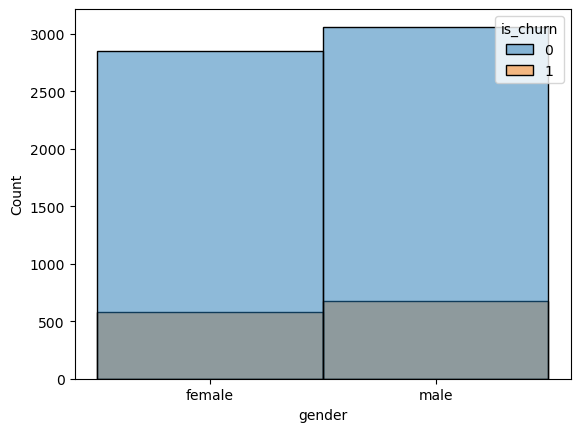

In [452]:
sns.histplot(data=train_gender, x='gender' ,hue='is_churn')

In [ ]:
## 10만개 샘플링 데이터 불러오기

In [3]:
train_df = pd.read_parquet('D:/kkbox-churn-prediction-challenge/data/sample/sample_ratio_0.107/sample_train.parquet/sample_train (ratio=0.107).parquet')
members_df = pd.read_parquet('D:/kkbox-churn-prediction-challenge/data/sample/sample_ratio_0.107/sample_members.parquet/sample_members (ratio=0.107).parquet')
transaction_df = pd.read_parquet('D:/kkbox-churn-prediction-challenge/data/sample/sample_ratio_0.107/sample_transactions.parquet/sample_transactions (ratio=0.107).parquet')
userlog_df = pd.read_parquet('D:/kkbox-churn-prediction-challenge/data/sample/sample_ratio_0.107/sample_user_logs.parquet/sample_user_logs (ratio=0.107).parquet')

In [42]:
import datetime

In [47]:
transaction_df['membership_expire_date'] = pd.to_datetime(transaction_df['membership_expire_date'])
transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'])

In [74]:
transaction_filter1 = (~((transaction_df.duplicated(['msno_num', 'transaction_date'], keep='first')) & (transaction_df['is_cancel'] == 0)))
transaction_filter2 = (~((transaction_df.duplicated(list(transaction_df.columns), keep='first')) & (transaction_df['is_cancel'] == 1)))
transaction_filter3 = (transaction_df['transaction_date'] < transaction_df['membership_expire_date'])

# kkbox 출시일인 2005년부터 시작하여 최대 구독 기간인 1년 + 30일(공짜로 줌) 이후까지
min_timestamp = pd.Timestamp(datetime.date(2005,1,1))
max_timestamp = pd.Timestamp(datetime.date(2018,4,1))

transaction_filter4 = ((transaction_df['membership_expire_date'] >= min_timestamp) & (transaction_df['membership_expire_date'] <= max_timestamp))

In [75]:
transaction_filtered = transaction_df[transaction_filter1&transaction_filter2&transaction_filter3&transaction_filter4]

In [76]:
transaction_filtered[transaction_filtered.duplicated(keep=False)]

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel


In [78]:
transaction_filtered[transaction_filtered.duplicated(['msno_num', 'transaction_date'],keep=False)]

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
554,56584,41,30,129,129,1,2015-04-07,2016-06-04,0
562,56584,41,30,149,149,1,2015-04-07,2016-05-05,1
1298,169320,36,30,180,180,1,2016-05-27,2016-06-26,0
1302,169320,40,30,149,149,1,2016-05-27,2016-06-26,1
2639,381957,40,0,0,149,1,2015-05-08,2015-07-05,0
...,...,...,...,...,...,...,...,...,...
1688796,6301421,41,30,149,149,1,2017-02-12,2017-02-13,1
1689173,6390977,40,30,149,149,1,2016-07-29,2016-09-27,0
1689180,6390977,39,30,149,149,1,2016-07-29,2016-08-24,1
1692102,7265393,41,30,99,99,1,2015-10-28,2015-11-30,0


In [64]:
cols = transaction_filtered.columns[1:9]

<AxesSubplot: >

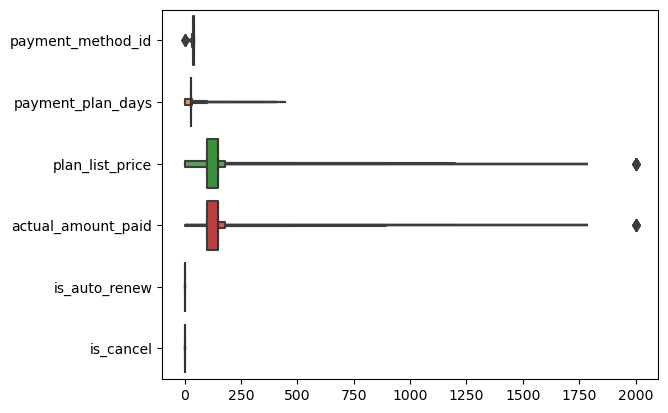

In [80]:
sns.boxenplot(data=transaction_filtered[cols], orient='h')

In [88]:
transaction_filtered[transaction_filtered['plan_list_price'] > 500]['plan_list_price'].unique()

array([1788,  894, 1599,  536,  799, 1200,  600,  699,  930,  596, 1299,
       1000, 1399, 1150, 2000])

In [90]:
transaction_filtered[transaction_filtered['plan_list_price'] > 1000]

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
23,4353,32,410,1788,1788,0,2016-01-14,2017-02-27,0
181,15870,22,410,1788,1788,0,2016-01-18,2017-03-06,0
595,62034,32,410,1788,1788,0,2015-12-25,2017-02-15,0
597,62513,38,410,1788,1788,0,2016-01-26,2017-03-11,0
831,97140,32,410,1788,1788,0,2015-12-23,2017-02-08,0
...,...,...,...,...,...,...,...,...,...
1688940,6316892,22,410,1788,1788,0,2015-06-28,2016-08-21,0
1689502,6481501,38,410,1788,1788,0,2016-02-07,2017-03-23,0
1691603,7084963,32,410,1788,1788,0,2016-02-10,2017-03-29,0
1691877,7175882,32,410,1788,1788,0,2015-04-18,2016-06-01,0


In [84]:
transaction_filtered[transaction_filtered['plan_list_price'] > 1788]

,msno_num,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
579279,551281,28,400,2000,2000,0,2016-01-03,2017-02-09,0
889614,6635617,28,400,2000,2000,0,2016-01-27,2017-03-05,0
943269,7047747,28,400,2000,2000,0,2016-01-27,2017-03-02,0
990152,6345186,28,400,2000,2000,0,2015-12-27,2017-02-02,0
1247892,48550,28,400,2000,2000,0,2015-10-05,2016-11-08,0
1343685,6452922,28,400,2000,2000,0,2015-11-22,2016-12-26,0


In [93]:
userlog_df[userlog_df['total_secs'] > 86400]

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1963,55265,2016-03-26,39,7,12,4,308,254,88180.145
19235,1168863,2016-12-08,84,20,19,27,1532,158,409138.154
19324,1168863,2016-09-01,24,6,3,5,488,83,128319.363
21225,1380401,2015-08-11,14,18,2,0,402,188,97585.948
21598,1380401,2015-07-18,6,2,2,5,610,211,145010.322
...,...,...,...,...,...,...,...,...,...
29754388,4599838,2016-08-03,0,1,0,0,452,232,117822.925
29769829,5367066,2016-07-13,0,0,0,0,393,20,86436.201
29786453,6316892,2016-06-02,7,2,2,1,469,174,114726.756
29799148,6748713,2017-03-18,7,3,1,2,200,69,88259.286


In [98]:
userlog_df[userlog_df['msno_num'] == 1168863].sort_values('date').head(60)

,msno_num,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
18968,1168863,2016-01-20,166,53,10,5,2,220,11423.119
18976,1168863,2016-01-21,5,3,2,0,66,52,16754.831
18984,1168863,2016-01-22,20,17,3,4,38,72,13119.267
18992,1168863,2016-01-23,7,6,7,2,29,47,9220.222
19000,1168863,2016-01-24,0,1,0,0,55,50,13476.213
19008,1168863,2016-01-26,1,1,0,0,24,22,5820.832
19016,1168863,2016-01-27,3,0,0,1,22,24,5752.891
19024,1168863,2016-01-28,0,0,0,0,11,9,2820.624
19032,1168863,2016-01-29,1,0,1,0,13,15,3118.835
19040,1168863,2016-01-30,4,0,0,0,31,31,7554.493


In [ ]:
train_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_train/new_train.parquet', inferSchema=True)
members_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_members/new_members.parquet', inferSchema=True)
transactions_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_transactions/new_transactions.parquet', inferSchema=True)
userlog_df_whole = spark.read.option('header', 'true').parquet('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/id_encoding/data/new_user_logs/new_user_logs-001.parquet', inferSchema=True)

In [5]:
userlog_df_whole.count()

410502905

In [14]:
transaction_grouped = transactions_df_whole.groupBy('msno_num').agg({'transaction_date' :'min','membership_expire_date' : 'max'})

In [16]:
transaction_grouped.printSchema()

root
 |-- msno_num: integer (nullable = true)
 |-- min(transaction_date): integer (nullable = true)
 |-- max(membership_expire_date): integer (nullable = true)



In [15]:
from pyspark.sql.functions import *

In [27]:
transactiongrouped = transaction_grouped.withColumn('transaction_date', to_date(col("min(transaction_date)").cast("string"), 'yyyyMMdd'))\
                                        .withColumn('membership_expire_date', to_date(col("max(membership_expire_date)").cast("string"), 'yyyyMMdd'))

In [32]:
transactiongrouped = transactiongrouped.withColumn("period", round(months_between(col("membership_expire_date"), col("transaction_date"))))
transactiongrouped.show()

+--------+---------------------+---------------------------+----------------+----------------------+------+
|msno_num|min(transaction_date)|max(membership_expire_date)|transaction_date|membership_expire_date|period|
+--------+---------------------+---------------------------+----------------+----------------------+------+
|    9427|             20150110|                   20170423|      2015-01-10|            2017-04-23|  27.0|
|    9900|             20151109|                   20151208|      2015-11-09|            2015-12-08|   1.0|
|   21700|             20150115|                   20170421|      2015-01-15|            2017-04-21|  27.0|
|   29894|             20150612|                   20150615|      2015-06-12|            2015-06-15|   0.0|
|   35689|             20151105|                   20160104|      2015-11-05|            2016-01-04|   2.0|
|   41946|             20170317|                   20170416|      2017-03-17|            2017-04-16|   1.0|
|   55265|             20150

In [56]:
ids_under_3months = transactiongrouped.filter(col('period').isin([12,13])).select('msno_num').toPandas()

In [60]:
ids_under_1415months = transactiongrouped.filter(col('period').isin([14,15])).select('msno_num').toPandas()

In [61]:
ids_under_1011months = transactiongrouped.filter(col('period').isin([10,11])).select('msno_num').toPandas()

In [64]:
msno_nums1213=list(ids_under_3months['msno_num'])
msno_nums1415=list(ids_under_1415months['msno_num'])
msno_nums1011=list(ids_under_1011months['msno_num'])

In [63]:
len(msno_nums1213)

113936

In [67]:
len(msno_nums1415), len(msno_nums1011)

(146595, 84973)

In [69]:
# Cache the DataFrame
train_df_whole.cache()

# Repartition the DataFrame
train_df_partitioned = train_df_whole.repartition(100)

In [70]:
train_df_whole.filter(col("msno_num").isin(msno_nums1011)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/train_1011.parquet')

In [71]:
# Unpersist the cached DataFrame
train_df_whole.unpersist()

DataFrame[msno_num: int, is_churn: int]

In [72]:
train_df_partitioned = train_df_whole.repartition(100)
members_df_whole = train_df_whole.repartition(100)
transactions_df_whole = train_df_whole.repartition(100)
userlog_df_whole = train_df_whole.repartition(100)

In [73]:
members_df_whole.filter(col("msno_num").isin(msno_nums1011)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/members_1011.parquet')
transactions_df_whole.filter(col("msno_num").isin(msno_nums1011)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/transactions_1011.parquet')
userlog_df_whole.filter(col("msno_num").isin(msno_nums1011)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/userlog_1011.parquet')

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\jiho\anaconda3\envs\ds_study\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "c:\Users\jiho\anaconda3\envs\ds_study\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
train_df_whole.filter(col("msno_num").isin(msno_nums1213)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/train_1213.parquet')
members_df_whole.filter(col("msno_num").isin(msno_nums1213)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/members_1213.parquet')
transactions_df_whole.filter(col("msno_num").isin(msno_nums1213)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/transactions_1213.parquet')
userlog_df_whole.filter(col("msno_num").isin(msno_nums1213)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/userlog_1213.parquet')

In [ ]:
train_df_whole.filter(col("msno_num").isin(msno_nums1415)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/train_1415.parquet')
members_df_whole.filter(col("msno_num").isin(msno_nums1415)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/members_1415.parquet')
transactions_df_whole.filter(col("msno_num").isin(msno_nums1415)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/transactions_1415.parquet')
userlog_df_whole.filter(col("msno_num").isin(msno_nums1415)).write.parquet('D:/kkbox-churn-prediction-challenge/data/sample_1213/userlog_1415.parquet')